# Modeling technical noise - example notebook
August George, PNNL, 2024

## imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import nocap.process as process

## generate example data 
using stratified uniform distributions (each gene/column has it's own uniform distribution)

In [5]:
num_genes = 200
num_cells = 100
np.random.seed(42)

clean_expression_data = process.generate_test_data_tensor(
    n_rows=num_cells, n_cols=num_genes, scale_dist_params=(1, 3)
)

gene_names = [f"gene{i+1}" for i in range(num_genes)]
sample_indices = [f"cell{i+1}" for i in range(num_cells)]
clean_expression_df = pd.DataFrame(clean_expression_data, columns=gene_names, index=sample_indices)

clean_expression_df.head()

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene191,gene192,gene193,gene194,gene195,gene196,gene197,gene198,gene199,gene200
cell1,446.294586,36.149208,22.515673,0.039011,2.168313,0.044286,1.959581,0.026539,0.298586,332.177063,...,0.345934,6.409266,0.577986,0.072705,0.042297,0.056482,7.815240,3.968296,1.349174,0.415433
cell2,392.087219,34.466408,36.650356,0.035658,14.150066,0.050805,1.524664,0.040337,0.120930,207.298492,...,0.364070,3.761487,4.145340,0.093800,0.043970,0.046046,2.128386,15.842263,2.120449,1.578243
cell3,85.847931,136.936066,9.662214,0.036061,4.521170,0.049633,1.290685,0.034517,0.144527,343.995453,...,0.206181,5.151886,1.499152,0.262352,0.044945,0.051271,4.887205,8.118134,6.875115,1.162554
cell4,785.656494,102.021622,19.569271,0.035392,10.041205,0.093600,1.634031,0.037651,0.290000,94.147888,...,0.437360,3.940284,3.198212,0.148195,0.042742,0.057073,8.590379,8.609227,2.398813,1.330149
cell5,447.471222,144.911743,24.094328,0.036986,8.276869,0.074413,0.467297,0.028857,0.273936,316.699066,...,0.195637,5.030766,5.012934,0.257775,0.043857,0.060221,7.664897,9.906755,5.269523,0.950932


## apply noise processes
using methods motivated by SERGIO (doi:[10.1016/j.cels.2020.08.003](https://doi.org/10.1016/j.cels.2020.08.003)):
1. biological noise --> log normal process
2. outliers --> Bernoulli + log normal process
3. library size effects --> row normalization and log normal scaling process
4. dropout effects --> quantile-based logicistic dropout process
5. UMI count effects --> Poisson process


In [6]:
data_w_bio_noise = process.apply_lognormal_noise_process(clean_expression_data)
outlier_data = process.apply_bernoulli_lognormal_outlier_process(data_w_bio_noise)
library_size_data = process.apply_row_normalization_and_lognormal_scaling_process(outlier_data)
dropout_data = process.apply_quantile_logistic_dropout_process(library_size_data)

## visualization
showing the log10 change in expression levels after applying the noise processes

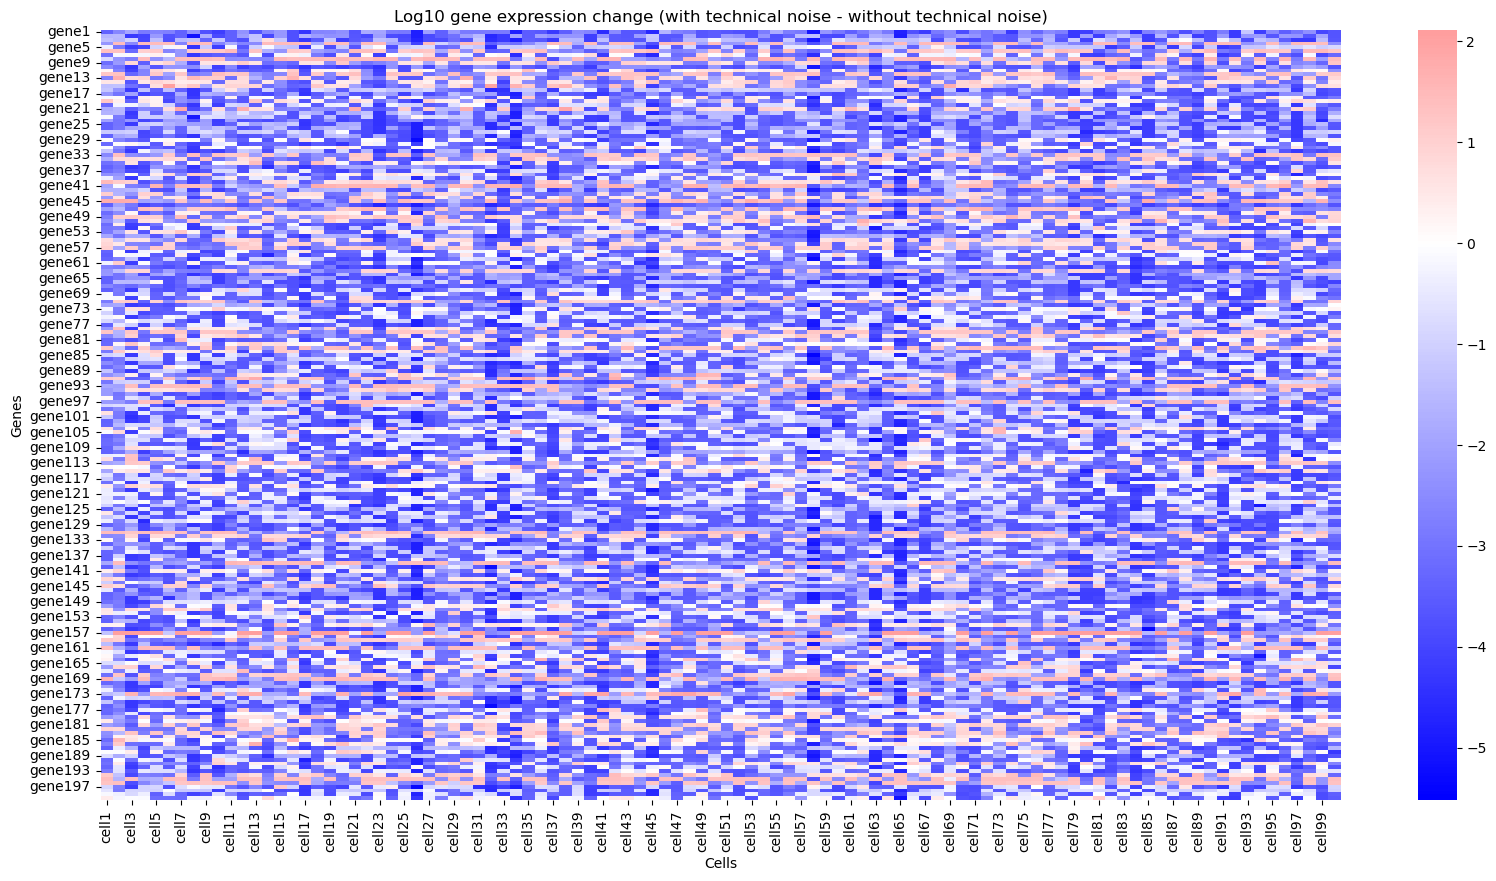

In [7]:
df1 = clean_expression_df
df2 = pd.DataFrame(dropout_data, columns=gene_names, index=sample_indices)
title = "Log10 gene expression change (with technical noise - without technical noise)"

df1_safe = df1.replace(0, 1)
df2_safe = df2.replace(0, 1)
log10_change = np.log10(df2_safe / df1_safe)

plt.figure(figsize=(20, 10))
sns.heatmap(log10_change.T, cmap="bwr", center=0, cbar=True)
plt.title(title)
plt.xlabel("Cells")
plt.ylabel("Genes")
plt.show()